In [2]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import skimage.color as color
from scipy.linalg import lstsq
import os


In [3]:
Z_raw = []
for i in range(1, 17):
    path = os.path.join('data/door_stack', 'exposure{}.tiff'.format(i))
    img = io.imread(path)
    Z_raw.append(img.flatten())
Z_raw = np.array(Z_raw).T 

Z = []
for i in range(1, 17):
    path = os.path.join('data/door_stack', 'exposure{}.jpg'.format(i))
    img = io.imread(path)
    img_d = img[::200,::200,:]
    Z.append(img_d.flatten())

Z = np.array(Z).T 

In [4]:
def get_shutter(k):
        #k is from 0 to 15
        return (2**(k))/2048

def gsolve(Z, l=500):

    B = np.array([np.log(get_shutter(k)) for k in range(16)])
    n = 256
    im_size = Z.shape[0] 
    num_im  = Z.shape[1]
    # initialize the A, b matrices
    A = np.zeros(((im_size*num_im)+n, n+im_size))
    b = np.zeros(A.shape[0])
    print(im_size, num_im)
    # data-fitting equations
    k = 0
    shutter = np.array([(2**(i))/2048 for i in range(16)])
    wij = np.zeros(Z.shape)
    
    zw = Z/255
    idx1, idx2 = np.where((zw >= 0.05) & (zw <= 0.95))
    wij[idx1, idx2] = shutter[idx2]
    
    for i in range(0, im_size):
        for j in range(0, num_im):
            A[k, Z[i,j]] = wij[i,j]
            A[k, n+i] = -wij[i,j]
            b[k] = wij[i,j] * B[j]
            k += 1
    # fix the curve - set middle value to zero
    A[k, 128] = 0
    k += 1
    pix = np.arange(0, n-2)
    wts = np.ones_like(pix) #weights(pix)
    # add smoothness equations
    for i in range(0, n-2):
        wt = l*wts[i]
        A[k, i] = wt
        A[k, i+1] = -2*wt
        A[k, i+2] = wt
        k += 1
    #print(k)
    x = np.linalg.lstsq(A, b)[0]
    g = x[:n]

    return g
    

1800 16


/var/folders/_q/d0ww93zs26b5hx__yj4hc21r0000gn/T/ipykernel_1990/4264668580.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


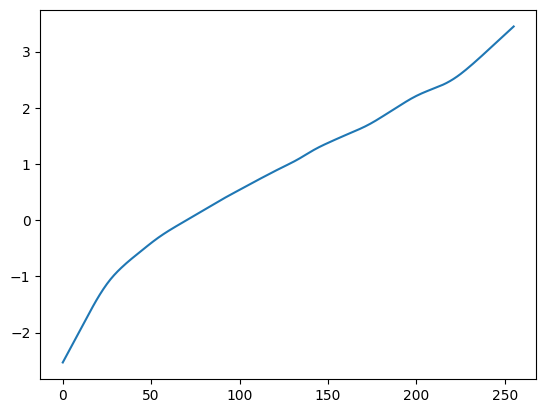

In [176]:
#Z = np.array(Z).T 
g = gsolve(np.array(Z))
plt.plot(np.arange(256), g)

In [121]:
w_raw = np.zeros(Z_raw.shape)
idx1, idx2 = np.where((Z_raw >= 0.05) & (Z_raw <= 0.95))
w_raw[idx1, idx2] = get_shutter(idx2)


In [5]:
def merge(Z, wij):

    B = np.array([get_shutter(k) for k in range(16)])
    B = B.reshape((16,1,1,1))

    B_k = np.tile(B, (1,Z.shape[1], Z.shape[2], Z.shape[3]))
    print(B_k.shape, wij.shape, Z.shape)

    #B_k = B.repeat((1,Z.shape[1], Z.shape[2], Z.shape[3]))
    num = wij*Z
    num /= B_k

    hdr = np.sum(num, 0)/np.sum(wij,0)

    return hdr.reshape(4000,6000,3)

In [6]:
Z_ldr = []
Z_lin = []
g = np.load('g.npy')

def apply_g(img, g):
    return np.exp(g[img])

for im in range(1, 17):
    path = os.path.join('data/door_stack', 'exposure{}.jpg'.format(im))
    img = io.imread(path)
    Z_ldr.append(img)
    Z_lin.append(apply_g(img, g))

Z_lin = np.array(Z_lin)
Z_ldr = np.array(Z_ldr)

Z_ldr = Z_ldr.astype(np.float64)
Z_ldr /= 255.0
Z_lin = Z_lin.astype(np.float64)
Z_lin /= 255.0

In [7]:
from src.cp_hw2 import writeHDR, readHDR
wij = np.zeros(Z_ldr.shape, dtype=np.float64)
idx1, idx2, idx3, idx4 = np.where((Z_ldr >= 0.05) & (Z_ldr <= 0.95))
wij[idx1, idx2, idx3, idx4] = get_shutter(idx1)
hdr = merge(Z_lin, wij)
writeHDR('door1.HDR', hdr)

(16, 4000, 6000, 3) (16, 4000, 6000, 3) (16, 4000, 6000, 3)


/var/folders/_q/d0ww93zs26b5hx__yj4hc21r0000gn/T/ipykernel_99170/1639741841.py:13: RuntimeWarning: invalid value encountered in divide
  hdr = np.sum(num, 0)/np.sum(wij,0)


Color correction of the hdr image

In [8]:
from src.cp_hw2 import read_colorchecker_gm
from matplotlib.pyplot import ginput
%matplotlib inline

hdr_crops = np.array([[[1420, 1500, 3350, 3400],
        [1250, 1350, 3350, 3400],
        [1100, 1180, 3350, 3400],
        [ 950, 1020, 3350, 3400],
        [ 780,  850, 3350, 3400],
        [ 650,  700, 3350, 3400]],
       [[1420, 1500, 3510, 3550],
        [1250, 1350, 3510, 3550],
        [1100, 1180, 3510, 3550],
        [ 950, 1020, 3510, 3550],
        [ 780,  850, 3510, 3550],
        [ 650,  700, 3510, 3550]],
       [[1420, 1500, 3630, 3710],
        [1250, 1350, 3630, 3710],
        [1100, 1180, 3630, 3710],
        [ 950, 1020, 3630, 3710],
        [ 780,  850, 3630, 3710],
        [ 650,  700, 3630, 3710]],
       [[1420, 1500, 3800, 3850],
        [1250, 1350, 3800, 3850],
        [1100, 1180, 3800, 3850],
        [ 950, 1020, 3800, 3850],
        [ 780,  850, 3800, 3850],
        [ 650,  700, 3800, 3850]]])

print(hdr_crops.shape) #4,6,4
r, g, b = read_colorchecker_gm()
cc_gt = np.dstack((r,g,b))

(4, 6, 4)


In [21]:
#4, 24
hdr = readHDR('hdr_jpg_1_3_ge_c.HDR')
cc_hdr = np.empty((4, 6, 3))

for i in range(hdr_crops.shape[0]):
    for j in range(hdr_crops.shape[1]):
        y_min, y_max, x_min, x_max = hdr_crops[i, j]
        print(y_min, y_max, x_min, x_max)
        crop_color = hdr[y_min:y_max,x_min:x_max,:]
        print(crop_color.shape)
        cc_hdr[i, j] = np.mean(crop_color, axis=(0,1))
    

1420 1500 3350 3400
(80, 50, 3)
1250 1350 3350 3400
(100, 50, 3)
1100 1180 3350 3400
(80, 50, 3)
950 1020 3350 3400
(70, 50, 3)
780 850 3350 3400
(70, 50, 3)
650 700 3350 3400
(50, 50, 3)
1420 1500 3510 3550
(80, 40, 3)
1250 1350 3510 3550
(100, 40, 3)
1100 1180 3510 3550
(80, 40, 3)
950 1020 3510 3550
(70, 40, 3)
780 850 3510 3550
(70, 40, 3)
650 700 3510 3550
(50, 40, 3)
1420 1500 3630 3710
(80, 80, 3)
1250 1350 3630 3710
(100, 80, 3)
1100 1180 3630 3710
(80, 80, 3)
950 1020 3630 3710
(70, 80, 3)
780 850 3630 3710
(70, 80, 3)
650 700 3630 3710
(50, 80, 3)
1420 1500 3800 3850
(80, 50, 3)
1250 1350 3800 3850
(100, 50, 3)
1100 1180 3800 3850
(80, 50, 3)
950 1020 3800 3850
(70, 50, 3)
780 850 3800 3850
(70, 50, 3)
650 700 3800 3850
(50, 50, 3)


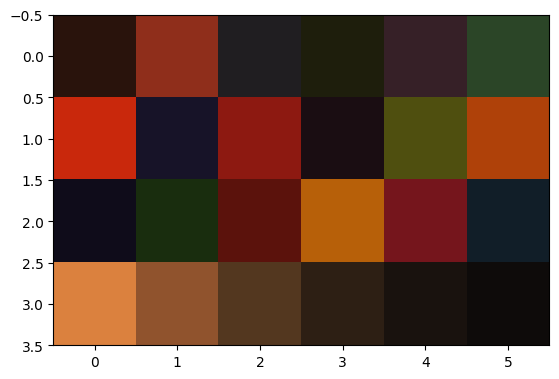

In [24]:
plt.imshow(cc_hdr*20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


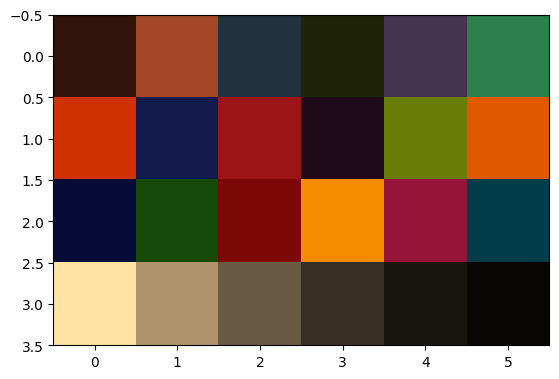

In [166]:
plt.imshow(cc_gt)

In [25]:
def color_correction(cc_gt, cc_hdr):
    b = np.ones((cc_gt.shape[0], cc_gt.shape[1], 1))
    cc_gt = cc_gt.reshape(-1,3)
    cc_hdr = np.concatenate([cc_hdr, b], axis = 2).reshape(-1,4)# 4,6,4

    A = np.empty((24*3, 12))
    b = np.empty((24*3, 1))
    for i in range(24):
        A[i*3:i*3+3, :] = [[*cc_hdr[i], *np.zeros(4), *np.zeros(4)],
                          [*np.zeros(4), *cc_hdr[i], *np.zeros(4)],
                          [*np.zeros(4), *np.zeros(4), *cc_hdr[i]]]
        
        b[i*3:i*3+3, 0] = [*cc_gt[i]]
    x = np.linalg.lstsq(A, b)[0]
    print(x.shape)
    return x

In [26]:
x = color_correction(cc_gt, cc_hdr)
x = x.reshape(3,4)

(12, 1)


/var/folders/_q/d0ww93zs26b5hx__yj4hc21r0000gn/T/ipykernel_95841/2074167378.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


In [27]:
hdr_4 = np.concatenate([hdr, np.ones((hdr.shape[0], hdr.shape[1], 1))], axis=2)#.reshape(-1,4)
hdr_cc = hdr_4@x.T
#hdr_cc = hdr_cc.T.reshape(4000,6000,3)
hdr_cc[hdr_cc<0]=0
writeHDR('door_cc_san.hdr', hdr_cc)

In [30]:
# Reinhard et al. 2002
hdr = readHDR('door_cc_san.hdr')
def tone_mapping(hdr_c, K=0.15, B=0.95):

    h, w = hdr_c.shape[:2]

    Im_hdr = np.exp(np.sum(np.log(hdr_c + 1e-8))/(h*w))
    Iij_hdr = K/Im_hdr * hdr_c
    I_white = B*np.max(Iij_hdr)

    I_tm = Iij_hdr*(1+Iij_hdr/I_white**2)/(1+Iij_hdr)
    return I_tm

hdr = readHDR('door_cc1.hdr')

I_tr = tone_mapping(hdr[:,:,0])
I_tg = tone_mapping(hdr[:,:,1])
I_tb = tone_mapping(hdr[:,:,2])

I_tm = np.dstack((I_tr, I_tg, I_tb))
writeHDR('door_tm1_san.hdr', I_tm)


In [33]:
from src.cp_hw2 import lRGB2XYZ, xyY_to_XYZ, XYZ2lRGB
hdr = readHDR('door_cc_san.hdr')
def XYZ_to_xyY(XYZ):
    X = XYZ[:, :, 0]
    Y = XYZ[:, :, 1]
    Z = XYZ[:, :, 2]
    x = X/(X+Y+Z)
    y = Y/(X+Y+Z)
    xyY = np.dstack((x, y, Y))
    return xyY

XYZ = lRGB2XYZ(hdr)
xyY = XYZ_to_xyY(XYZ)
xyY_tm = tone_mapping(xyY[:,:,-1])

X, Y, Z  = xyY_to_XYZ(xyY[:,:,0], xyY[:,:,1], xyY_tm)
XYZ_tm = np.dstack((X, Y, Z))
hdr_tm = XYZ2lRGB(XYZ_tm)
writeHDR('door_tm2_san.HDR', I_tm)